In [1]:
%reset -f
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%cd /home/psimmerl/Documents/work/EasyAI

import numpy as np
import matplotlib as mplX
import matplotlib.pyplot as plt
# mpl.rcParams['figure.dpi'] = 100

from src.models.gan import GenerativeAdversarialNetwork

# import os
# from pathlib import Path
# paths = sorted(Path('data/interim/').iterdir(), key=os.path.getmtime)
# print(paths[0])
# epoch = int(paths[0].name.split('epoch')[1].split('.')[0])
mname, epoch = 'model', 3
print(f'Using {mname}')

trn  = np.load(f'data/interim/{mname}/trn.npy')#/{epoch}
gen  = np.load(f'data/interim/{mname}/gen.npy')#/{epoch}
dtrn = np.load(f'data/interim/{mname}/dtrn.npy')#/{epoch}
dgen = np.load(f'data/interim/{mname}/dgen.npy')#/{epoch}
print(trn.shape)

nbins = 50
binfo = [
  ['ePt',       'Electron $P_t$',  '[GeV]', nbins, 0, 100],
  ['eEta',      'Electron $\eta$', '', nbins, 0, 100],
  ['kpPt',      'Kaon$^+$ $P_t$',  '[GeV]', nbins, 0, 100],
  ['kpEta',     'Kaon$^+$ $\eta$', '', nbins, 0, 100],
  ['kmPt',      'Kaon$^-$ $P_t$',  '[GeV]', nbins, 0, 100],
  ['kmEta',     'Kaon$^-$ $\eta$', '', nbins, 0, 100],
  ['ekpAngle',  'Angle[Electron, Kaon$^+$]', '[deg]', nbins, 0, 100],
  ['ekmAngle',  'Angle[Electron, Kaon$^+$]', '[deg]', nbins, 0, 100],
  ['kpkmAngle', 'Angle[Kaon$^+$, Kaon$^-$]', '[deg]', nbins, 0, 100],
  # ['phim',      'Invariant K$^+$K$^-$ Mass', 'Mass [GeV]', nbins, 0, 100],
  # ['mm2',       'Missing Mass$^2$', 'Mass$^2$ [GeV$^2$]', nbins, 0, 100],
  ['q2',        '$Q^2$', '$Q^2$ [GeV$^2$]', nbins, 0, 100],
]

for i, (tt, gg) in enumerate(zip(trn.T, gen.T)):
  if 'deg' in binfo[i][2]:
    tt *= 180 / np.pi
    gg *= 180 / np.pi

  # xmin, xmax = np.min([tt, gg]), np.max([tt, gg])
  xmin, xmax = np.quantile([tt, gg], 0.01), np.quantile([tt, gg], 0.99)
  binfo[i][4:6] = (xmin, xmax)

/home/psimmerl/Documents/work/EasyAI
Using model
(399287, 10)


In [2]:
np.isnan(trn).any()

False

In [3]:
diff = np.sum(trn-gen, axis=1)
print(f'MAE - {np.mean(np.abs(diff)):.3f}')
print(f'MSE - {np.mean(diff**2)**(1/2):.3f}')

MAE - 18.554
MSE - 23.234


In [4]:
dd = {'test1': (12, 34), 'test2': (56, 78),}
keys, vals = dd.keys(), [dd[k] for k in dd]
# keys, vals = np.array(keys), np.array(vals)

1677.619099147973


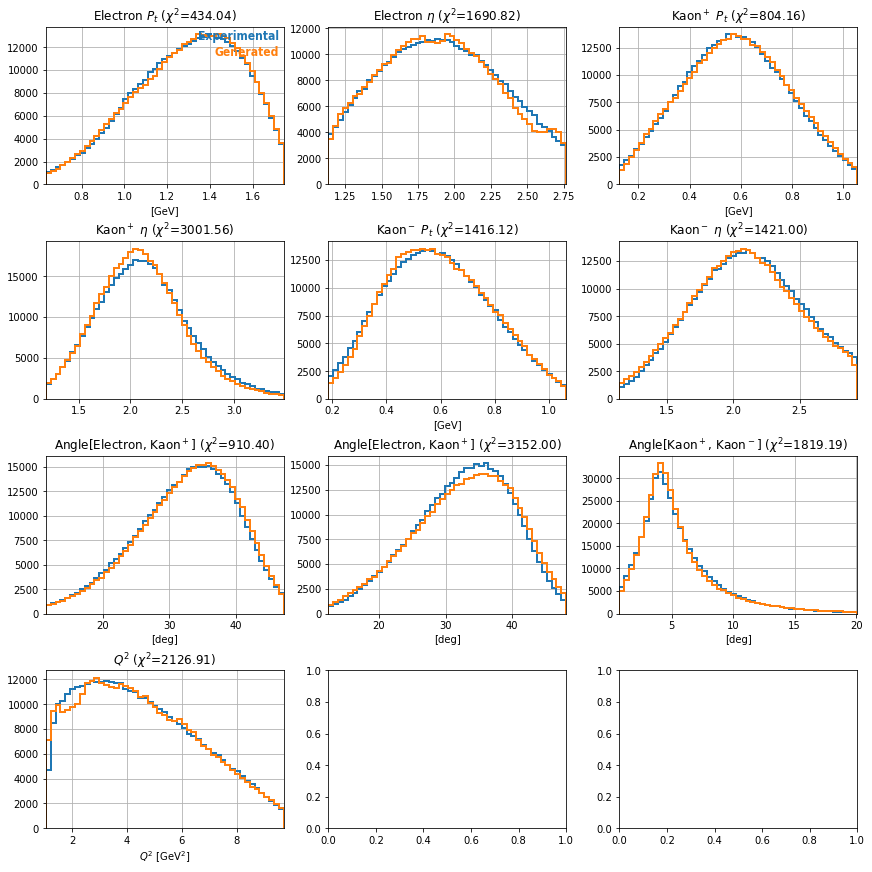

In [5]:
f, axs = plt.subplots(4,3, figsize=(12,12), constrained_layout=True)
axs = axs.flatten()
chi2_tot = 0
for iax, (ax, tt, gg) in enumerate(zip(axs, trn.T, gen.T)):
  feat, title, xlab, nbins, xmin, xmax = binfo[iax]
  bins = np.linspace(xmin, xmax, nbins)

  tvals, _, _ = ax.hist(tt, histtype='step', bins=bins, lw=2, label='Experimental')
  gvals, _, _ = ax.hist(gg, histtype='step', bins=bins, lw=2, label='Generated')
  
  ax.set_xlim((xmin,xmax))
  ax.grid(True)

  chi2 = np.sum((tvals-gvals)**2/np.fmax(1, tvals))
  chi2_tot += chi2

  ax.set_title(title + f' ($\chi^2$={chi2:.2f})')
  ax.set_xlabel(xlab)

axs[0].text(0.98, 0.98, 'Experimental', ha='right', va='top', transform=axs[0].transAxes, c='C0', weight='bold', stretch='condensed', size=12)
axs[0].text(0.98, 0.88, 'Generated', ha='right', va='top', transform=axs[0].transAxes, c='C1', weight='bold', stretch='condensed', size=12)

print(chi2_tot / trn.shape[1])


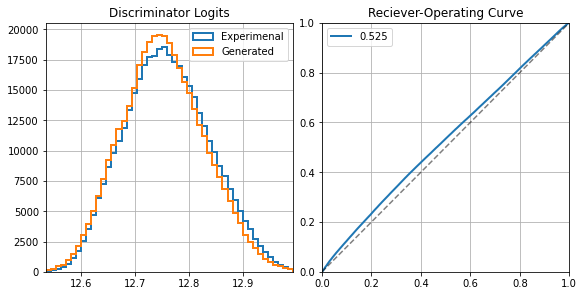

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
f, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axs = axs.flatten()

xmin, xmax = np.quantile([dtrn, dgen], 0.001), np.quantile([dtrn, dgen], 0.999)
bins = np.linspace(xmin, xmax, 50)
axs[0].hist(dtrn, histtype='step', bins=bins, lw=2, label='Experimenal')
axs[0].hist(dgen, histtype='step', bins=bins, lw=2, label='Generated')
axs[0].set_xlim((xmin,xmax))
axs[0].grid(True)
axs[0].legend()
axs[0].set_title('Discriminator Logits')

dis_score = np.c_[dtrn, dgen].flatten()
dis_label = np.c_[np.ones_like(dtrn), np.zeros_like(dgen)].flatten()
fpr, tpr, thresholds = roc_curve(dis_label, dis_score)
roc_auc = roc_auc_score(dis_label, dis_score)

axs[1].plot(fpr, tpr, label=f'{roc_auc:.3f}', lw=2)
axs[1].plot([0,1],[0,1], 'k--', alpha=0.5)
axs[1].grid(True)
axs[1].legend()
axs[1].set_xlim((0,1))
axs[1].set_ylim((0,1));
axs[1].set_title('Reciever-Operating Curve');
